In [1]:
import tensorflow as tf
print(tf.__version__)

/anaconda3/envs/dlcv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.0.0


In [2]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv -O /tmp/sunspots.csv

--2019-10-06 23:48:37--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com... 172.217.160.144
Connecting to storage.googleapis.com|172.217.160.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.05s   

2019-10-06 23:48:38 (1.43 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [3]:
import csv

sunspots = []
time_step = []
with open('/tmp/sunspots.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

In [4]:
import numpy as np

series = np.array(sunspots)
time = np.array(time_step)

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000    

In [6]:
def windowed_dataset(series, window_size, shuffle_buffer, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
def get_3_layer_DNN():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    return model

In [8]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

_3_layer_model = get_3_layer_DNN()
_3_layer_model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)
history = _3_layer_model.fit(dataset, epochs=100, verbose=0)

In [9]:
def forecaster(_model):
    forecast = []

    for time in range(len(series) - window_size):
        forecast.append(_model.predict(series[time:time + window_size][np.newaxis]))
    
    forecast = forecast[split_time - window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results

In [10]:
_3_layer_results = forecaster(_3_layer_model)

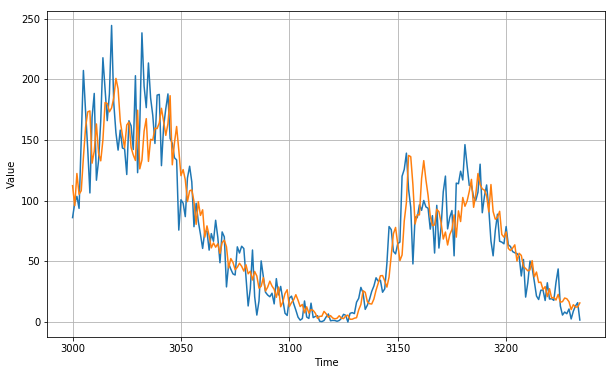

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, _3_layer_results)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, _3_layer_results).numpy()

17.176552